In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from utils import set_plots_size_params, plot_overview 

In [2]:
stuff_in_this_dir = os.listdir()
freqs = {}
for thing in stuff_in_this_dir:
    if thing.startswith('p'):
        freqs_file = os.listdir(thing)[0]
        freqs_name = freqs_file.split('.')[0]
        passage, km = freqs_name.split("-")
        passage = passage[1:]
        km = km[-1]
        freqs[freqs_name] = pd.read_table(os.path.join(thing, freqs_file))
        freqs[freqs_name]['passage'] = passage
        freqs[freqs_name]['km'] = km

In [3]:
freqs.keys()

dict_keys(['p7-KM2', 'p9-KM3', 'p3-KM2', 'p5-KM3', 'p10-KM1', 'p3-KM1', 'p5-KM2', 'p10-KM3', 'p1-KM2', 'p7-KM3', 'p10-KM2', 'p3-KM3', 'p1-KM1', 'p1-KM3', 'p7-KM1', 'p5-KM1'])

In [4]:
km1 = {key: df for key, df in freqs.items() if key[-1]=="1"}
km2 = {key: df for key, df in freqs.items() if key[-1]=="2"}
km3 = {key: df for key, df in freqs.items() if key[-1]=="3"}

In [5]:
km1.keys()

dict_keys(['p10-KM1', 'p3-KM1', 'p1-KM1', 'p7-KM1', 'p5-KM1'])

In [6]:
km3.keys()

dict_keys(['p9-KM3', 'p5-KM3', 'p10-KM3', 'p7-KM3', 'p3-KM3', 'p1-KM3'])

In [7]:
freqs = pd.concat(freqs.values())

In [8]:
freqs['km'] = freqs['km'].astype(int)
freqs['passage'] = freqs['passage'].astype(int)
freqs.sort_values(['km','passage','Pos'], inplace=True)

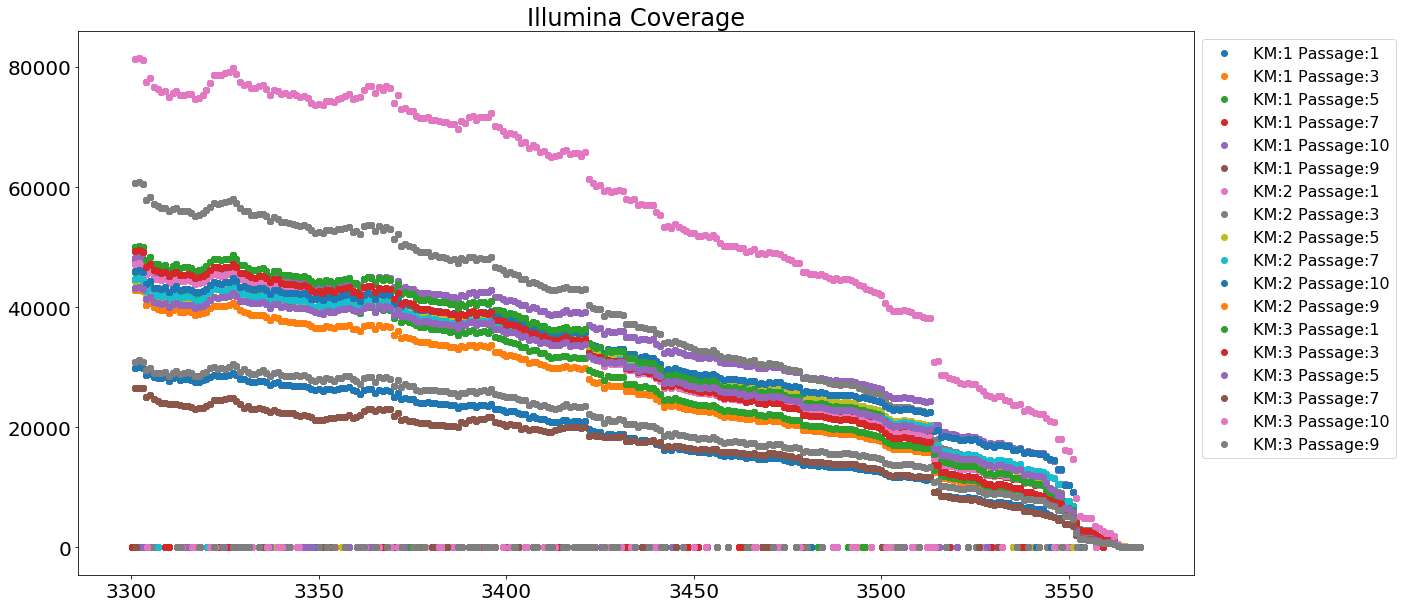

In [19]:
plt.figure(figsize=(20, 10))
for km in freqs.km.unique():
    for pas in freqs.passage.unique():
        df = freqs[freqs.km==km]
        df = df[df.passage==pas]
        df = df[df.Pos>3300]
        plt.scatter(df.Pos, df.Read_count, label=f"KM:{km} Passage:{pas}")
plt.legend(bbox_to_anchor=(1, 1))
plt.title("Illumina Coverage")
plt.savefig('illumina_coverage_end.png')

Getting Mutation Data...
Creating graphs!


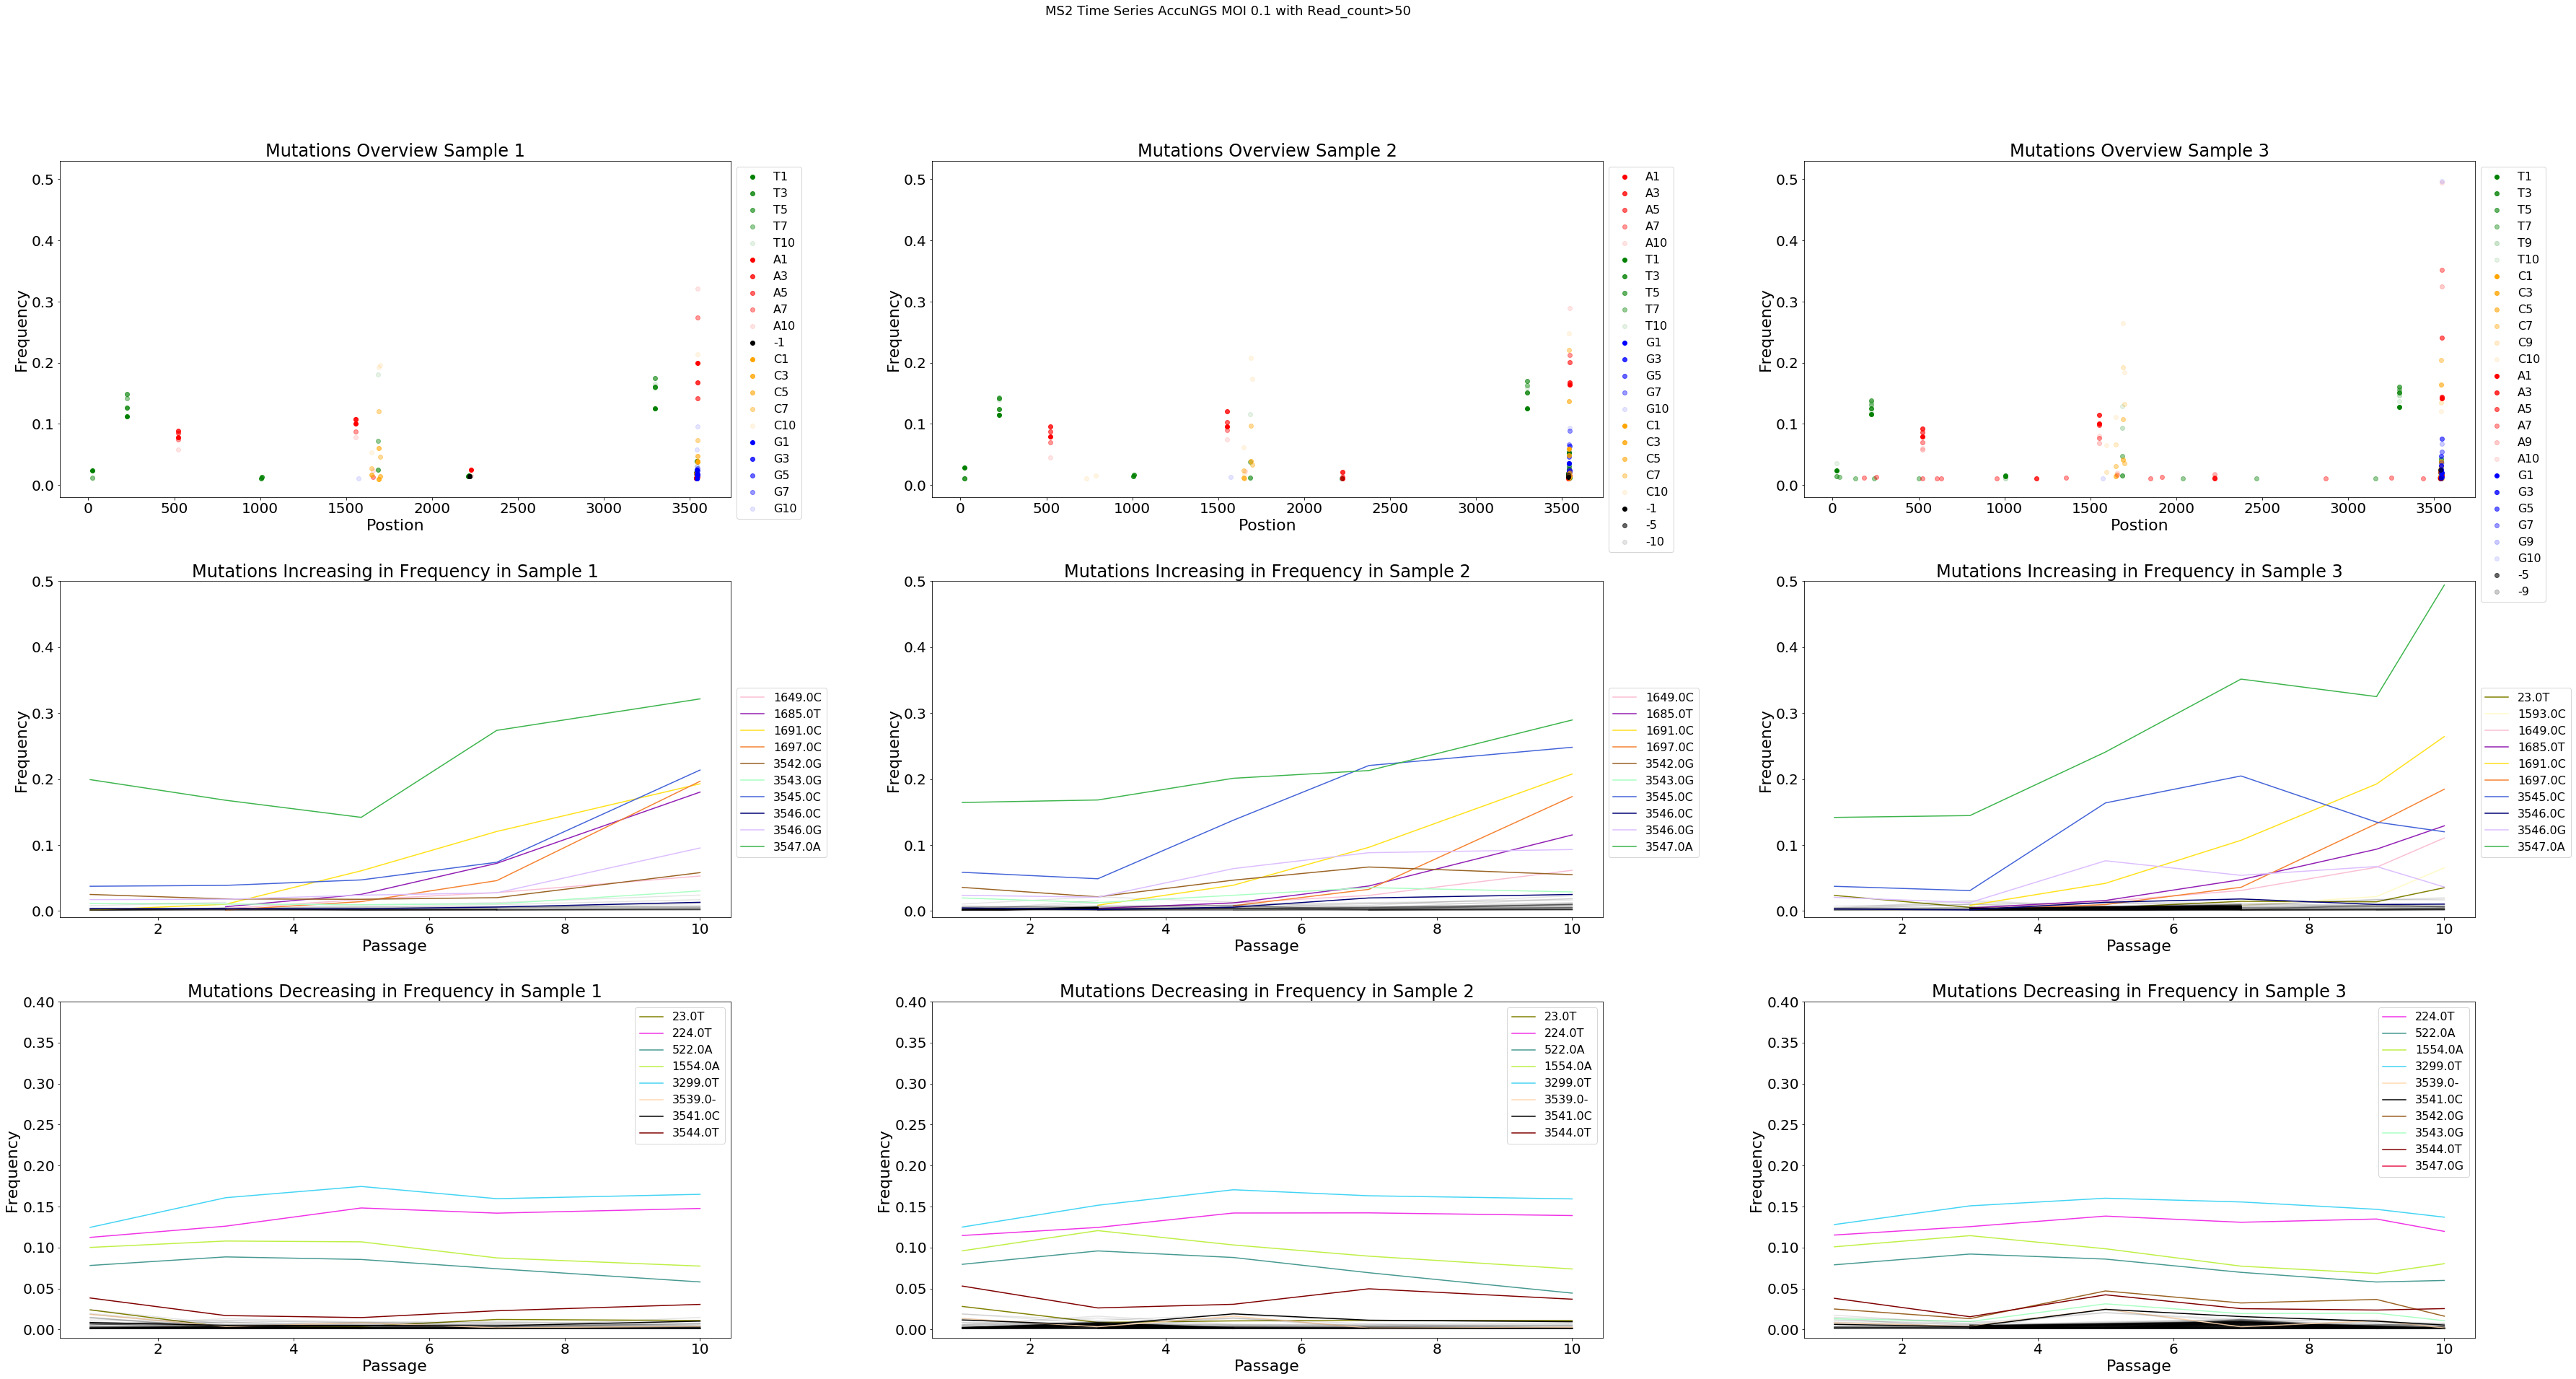

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [10]:
set_plots_size_params(20)
fig, axes = plot_overview(freqs)

In [12]:
def get_illumina_freqs():
    stuff_in_this_dir = os.listdir()
    freqs = {}
    for thing in stuff_in_this_dir:
        if thing.startswith('p'):
            freqs_file = os.listdir(thing)[0]
            freqs_name = freqs_file.split('.')[0]
            passage, km = freqs_name.split("-")
            passage = passage[1:]
            km = km[-1]
            freqs[freqs_name] = pd.read_table(os.path.join(thing, freqs_file))
            freqs[freqs_name]['passage'] = passage
            freqs[freqs_name]['km'] = km 
    freqs = pd.concat(freqs.values())   
    freqs['km'] = freqs['km'].astype(int)
    freqs['passage'] = freqs['passage'].astype(int)
    freqs.sort_values(['km','passage','Pos'], inplace=True)
    return freqs
ifreqs = get_illumina_freqs()
ifreqs.equals(freqs)

In [11]:
#fig.savefig('illumina_overview.png')